In [2]:
# Pooja Ganesh
# UIUC
# Task : Car Brand Prediction using multiclass classification with Finetuning on Pretrained Models.
# GPU Cloud : Runpod.io
# Data Source : Kaggle (exact link on git)
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 103.1 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 133.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 163.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [17]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.8 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cars_data_10'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

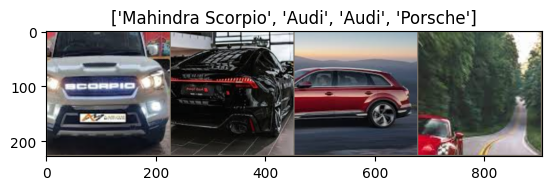

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [60]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # Initialize lists to store losses and accuracies
        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []


        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Store losses and accuracies in respective lists
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                else:
                    test_losses.append(epoch_loss)
                    test_accs.append(epoch_acc)

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, train_accs, test_losses, test_accs

In [62]:
# Plotting loss and accuracies for training and validation
def plot_losses_accuracies(train_losses, train_accs, test_losses, test_accs):
    """
    Plots the training and validation losses and accuracies.

    Args:
        train_losses (list): List of training losses per epoch.
        train_accs (list): List of training accuracies per epoch.
        test_losses (list): List of validation losses per epoch.
        test_accs (list): List of validation accuracies per epoch.
    """

    import matplotlib.pyplot as plt
    
    epochs = range(len(train_accs))  # Create epochs list for plotting

    # Move tensors to CPU if necessary
    train_losses = [l.cpu() if isinstance(l, torch.Tensor) else l for l in train_losses]
    train_accs = [a.cpu() if isinstance(a, torch.Tensor) else a for a in train_accs]
    test_losses = [l.cpu() if isinstance(l, torch.Tensor) else l for l in test_losses]
    test_accs = [a.cpu() if isinstance(a, torch.Tensor) else a for a in test_accs]

    #epochs = epochs.to(device)
    #epochs.cpu()
    # Plot accuracy
    plt.plot(epochs, train_accs, 'r', label='Training accuracy')
    plt.plot(epochs, test_accs, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot loss
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, test_losses, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


In [93]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            #print(type(inputs))
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                print(f'true: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])
                #print(type(inputs.cpu()))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [94]:
import torch.nn.functional as F
import torch
from torcheval.metrics import MulticlassF1Score, MulticlassPrecision, MulticlassAccuracy

def evaluate_model(model, dataloader, criterion, num_classes=10, average="macro", k=2, criteria="exact_match"):

    model.eval()  # Set model to evaluation mode

    total_loss = 0  # Initialize to accumulate loss over all batches

    # Create metrics with appropriate averaging
    f1_metric = MulticlassF1Score(num_classes=num_classes, average=average)
    precision_metric = MulticlassPrecision(num_classes=num_classes, average=average)
    acc = MulticlassAccuracy(num_classes=num_classes, average=average)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Calculate loss for the current batch
            batch_loss = criterion(outputs, labels).item()
            total_loss += batch_loss

            if torch.nn.functional.softmax(model(inputs), dim=-1).shape == outputs.shape:  # Ensure softmax alignment
                f1_metric.update(outputs, labels)
                precision_metric.update(outputs, labels)
                #labels_onehot = F.one_hot(labels, num_classes=num_classes)
                acc.update(outputs, labels)

    # Calculate average loss over all batches
    average_loss = total_loss / len(dataloader)

    # Compute multi-class metrics
    f1_score = f1_metric.compute()
    precision_score = precision_metric.compute()
    accuracy = acc.compute()

    return f1_score, precision_score, accuracy, average_loss



In [95]:
# CHANGE MODEL AS PER CONVENIENCE
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [96]:
%%time
import warnings
warnings.filterwarnings("ignore")

model_resnet, train_losses, train_accs, test_losses, test_accs = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.6668 Acc: 0.4510
test Loss: 1.2512 Acc: 0.6169

Epoch 1/19
----------
train Loss: 1.2462 Acc: 0.5935
test Loss: 0.6728 Acc: 0.7840

Epoch 2/19
----------
train Loss: 1.0779 Acc: 0.6499
test Loss: 0.7711 Acc: 0.7744

Epoch 3/19
----------
train Loss: 0.9381 Acc: 0.7045
test Loss: 0.5219 Acc: 0.8262

Epoch 4/19
----------
train Loss: 0.9158 Acc: 0.7156
test Loss: 0.3617 Acc: 0.8891

Epoch 5/19
----------
train Loss: 0.7927 Acc: 0.7484
test Loss: 0.3445 Acc: 0.8972

Epoch 6/19
----------
train Loss: 0.7392 Acc: 0.7648
test Loss: 0.2835 Acc: 0.9142

Epoch 7/19
----------
train Loss: 0.5378 Acc: 0.8289
test Loss: 0.2363 Acc: 0.9275

Epoch 8/19
----------
train Loss: 0.5102 Acc: 0.8440
test Loss: 0.2304 Acc: 0.9194

Epoch 9/19
----------
train Loss: 0.4968 Acc: 0.8497
test Loss: 0.1983 Acc: 0.9364

Epoch 10/19
----------
train Loss: 0.4705 Acc: 0.8527
test Loss: 0.2028 Acc: 0.9305

Epoch 11/19
----------
train Loss: 0.4604 Acc: 0.8539
test Loss: 0.1865 Acc

In [70]:
# Saving the model weights
model_weights_path = "./model_weights_resnet18.pth"
torch.save(model_resnet18.state_dict(), model_weights_path)

In [28]:
print(type(train_accs[1]))

<class 'torch.Tensor'>


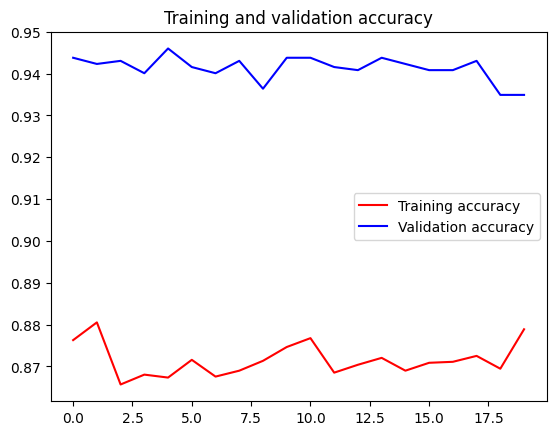

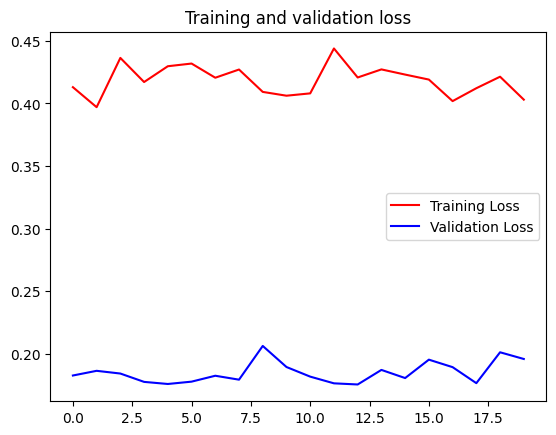

In [67]:
# Plots for loss and acc
plot_losses_accuracies(train_losses, train_accs, test_losses, test_accs)

In [98]:
#from sklearn.metrics import classification_report,confusion_matrix
#predictions = model_resnet18.predict(dataloaders['test'])
#predictions=np.argmax(predictions,axis=-1)
#dict_cls = dataloaders['test'].class_indices
#print(classification_report(dataloaders['test'].labels, predictions, target_names = list(dict_cls.keys())))
f1_score, precision_score, accuracy, average_loss = evaluate_model(model_resnet18, dataloaders['test'], criterion)

In [99]:
print(f1_score, precision_score, accuracy)

tensor(0.9503) tensor(0.9477) tensor(0.9536)


true: BMW


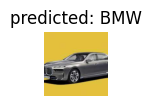

true: Hyundai Creta


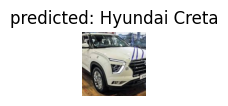

true: BMW


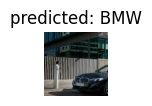

true: Porsche


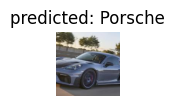

true: Mahindra Scorpio


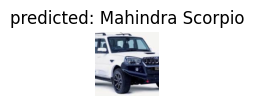

true: Tata Safari


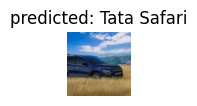

true: Toyota Innova


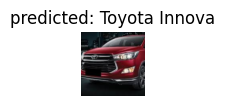

true: Porsche


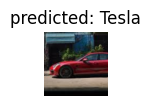

true: Audi


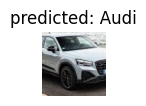

true: Tata Safari


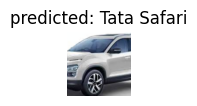

In [100]:
visualize_model(model_resnet18)